In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

#Next we are normalizing pixel vals to 0/1
mnist = fetch_openml('mnist_784', version=1) 
X = mnist.data.to_numpy().astype(np.float32) / 255.0  
y = mnist.target.to_numpy().astype(int)

We importede the MNIST dataset, normalized the pixels.
We will run quick test to make sure it is all working by pulling out a sample <br>
reshaping it back into 28x28 and plotting it in grayscale.

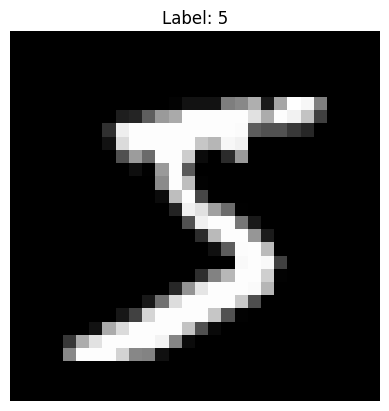

In [2]:
#quick test
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

# Task 1: PCA
Here we are going to run PCA, which is a dimensionality-reduction technique where the greatest <br>
variance is recorded in our data. It then displays the MNIST vectors into K components to get a <br>
2D visual that preserves as much of the variance as possible.

## 1-A

In [4]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

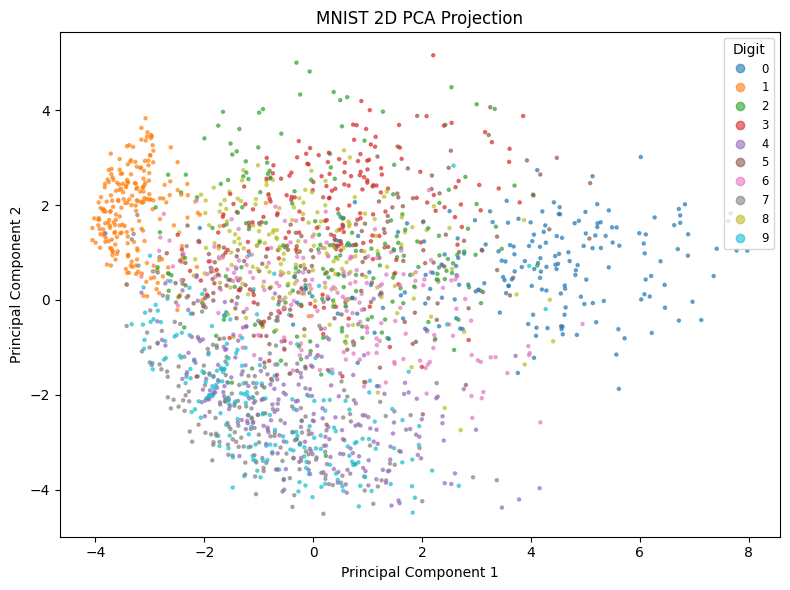

In [5]:
import matplotlib.pyplot as plt

n_plot = 2000 #we are only plotting part of it for visibility and speed
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca2[:n_plot, 0], 
    X_pca2[:n_plot, 1], 
    c=y[:n_plot], 
    cmap='tab10',
    s=5,
    alpha=0.6
)
plt.legend(*scatter.legend_elements(), title="Digit", loc="upper right", fontsize='small')
plt.title("MNIST 2D PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


Here we are seeing clustering by digits, though you may notice that the cluserting is pretty loose and <br>
there are many overlaps, much of the overlap is due to PCA being linear and using only 2 <br>
components.

Even though there is overlap, this is also shows that meaningfull structure is being captured

## 1-B,C,D
Here we focus a bit more on compressing and reconstructing, we are now using 32 <br>
componenents meaning we will capture more of the variance. In the process, the <br>
782 dim image will be compressed down to 32 dim. And then we reverse this compression <br>
to compute how much data was lost (MSE)

In [9]:
from sklearn.decomposition import PCA

pca32 = PCA(n_components=32)

X_pca32 = pca32.fit_transform(X)

In [10]:
import numpy as np

X_rec32 = pca32.inverse_transform(X_pca32)

mse32 = np.mean((X - X_rec32) ** 2)
print(f"Reconstruction MSE (32D PCA): {mse32:.6f}")

Reconstruction MSE (32D PCA): 0.017180


Pixel values  range 0 to 1. So the average reconstructed pixel <br>
differs from the original by about  0.017180

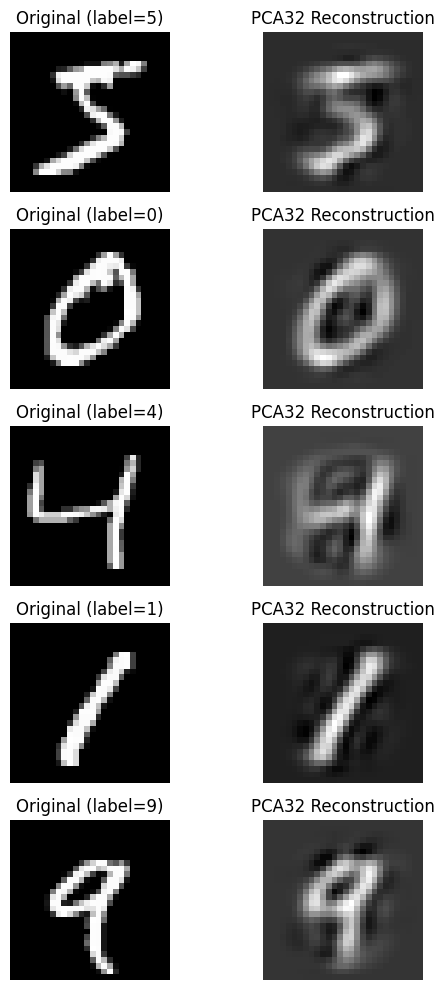

In [11]:
import matplotlib.pyplot as plt

n_show = 5
fig, axes = plt.subplots(n_show, 2, figsize=(6, 2*n_show))

for i in range(n_show):
    # orig
    axes[i,0].imshow(X[i].reshape(28,28), cmap='gray')
    axes[i,0].set_title(f"Original (label={y[i]})")
    axes[i,0].axis('off')
    # reconcstructed
    axes[i,1].imshow(X_rec32[i].reshape(28,28), cmap='gray')
    axes[i,1].set_title("PCA32 Reconstruction")
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()


PCA seems to do better with linear compression, but its still capturing a good <br>
amount of digit structures.

# Task 2

## Task 2-a
We will start by defining an encoder and decoder, then we will wrap <br>
those two into an autoencoder

We encode to compress the image into  32-dim,
and we decode to reconstruct the 32-dim back into a 784 vector

In [12]:
import torch.nn as nn

class Encoder(nn.Module):
     def __init__(self):
         super().__init__()
         self.encoder_layer = nn.Linear(784, 32) #784 inpute features and 32 latent
         self.activation = nn.ReLU() # we will use Relu

     def forward(self, x):
         x = self.encoder_layer(x)
         x = self.activation(x)
         return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_layer = nn.Linear(32, 784)
        self.activation = nn.Sigmoid() #get input back in 1 and 0

    def forward(self, z):
        z = self.decoder_layer(z)
        z = self.activation(z)
        return z


In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

## Task 2-b
Next we need to setup the compondents needed to train<br>
Device, we choose GPU (cuda) but if we cant we fall back to CPU<br>
autoencoder starts the model and moves it to the available device<br>
citerion stores the reconstruction error as we have seen in PCA<br>
optimizer ajusts teh encoder and decoder weights

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder().to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)


Here we are prepping the data loader to be used in the training, <br>
the tensorDataset is wrapping each image with itself as teh label and <br>
the dataloader feeds random batches of images(128 per iteration)

In [22]:
X_tensor = torch.from_numpy(X).to(device)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [25]:
autoencoder.train()
running_loss = 0.0

for inputs, targets in dataloader:
    optimizer.zero_grad() # resets gradient for each batch
    recon = autoencoder(inputs)
    loss = criterion(recon, targets) #comp the MSE
    loss.backward()
    optimizer.step() #we need to update the weights
    
    running_loss += loss.item() * inputs.size(0) #tot loss

epoch_loss = running_loss / len(dataset)
print(f"Epoch 1 Loss: {epoch_loss:.6f}") #print the avg loss per img

Epoch 1 Loss: 0.021424


since it ran well, we can move on to running multiple epochs

Epoch  1 Loss: 0.015139
Epoch  2 Loss: 0.015073
Epoch  3 Loss: 0.015045
Epoch  4 Loss: 0.015017
Epoch  5 Loss: 0.014989
Epoch  6 Loss: 0.014946
Epoch  7 Loss: 0.014922
Epoch  8 Loss: 0.014899
Epoch  9 Loss: 0.014869
Epoch 10 Loss: 0.014845


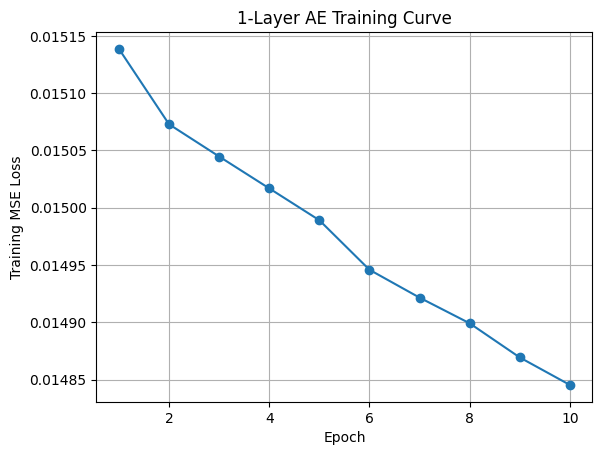

In [27]:
num_epochs = 10
train_losses = []

for epoch in range(1, num_epochs+1):
    autoencoder.train()
    running_loss = 0.0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        recon = autoencoder(inputs)
        loss = criterion(recon, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch:2d} Loss: {epoch_loss:.6f}")

import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training MSE Loss")
plt.title("1‐Layer AE Training Curve")
plt.grid(True)
plt.show()

Here we have the training MSE over 10 epochs.We can see that over that after each epoch, <br>
the recontruction done by the AE is able to hold on to more fine details from the original <br>
image.

On average AE was able to reconstruct images better than PCA considering they both had the <br>
same bottle neck of32 components

## Task 2-c
Next we are going to compare the original and reconstructed images side by side

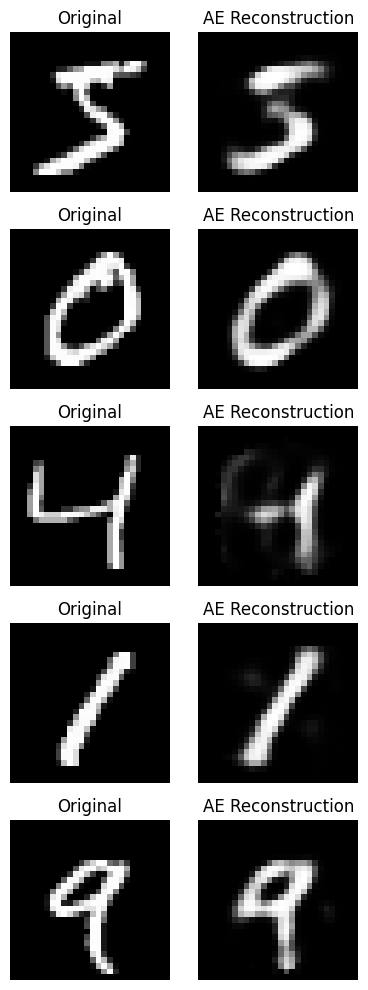

In [28]:
import matplotlib.pyplot as plt
import torch

autoencoder.eval()
with torch.no_grad():
    sample = X_tensor[:5]
    recon = autoencoder(sample)  

#cpu will by used for plotting
orig_np = sample.cpu().numpy()
recon_np = recon.cpu().numpy()

#plot
n_show = orig_np.shape[0]
fig, axes = plt.subplots(n_show, 2, figsize=(4, 2*n_show))

for i in range(n_show):
    axes[i,0].imshow(orig_np[i].reshape(28,28), cmap='gray')
    axes[i,0].set_title("Original")
    axes[i,0].axis('off')
    
    axes[i,1].imshow(recon_np[i].reshape(28,28), cmap='gray')
    axes[i,1].set_title("AE Reconstruction")
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()


Now that we have a visual, clearly the AE reconstruction using the single layer <br>
is doing better than teh PCA. But before we conclude anything we will compute tge <br>
full dataset MSE and compare that to PCA

In [29]:
autoencoder.eval()

with torch.no_grad():
    recon_all = autoencoder(X_tensor)
    ae_mse = criterion(recon_all, X_tensor).item()

print(f"1-Layer AE Reconstruction MSE: {ae_mse:.6f}")

1-Layer AE Reconstruction MSE: 0.014800


Here we got a reconstruction MSE of 0.014800 vs the 0.01718 that we got from PCA<br>
Ignoring the numbers, I noticed in PCA that there was a lot of ghosting. Meaning <br>
i saw phantom strokes and just a ton of blur, the background was not black like in <br>
the reconstruction using AE. I did notice that the AE reconstruction of 4 resembles <br>
more of a 9, but other than that AE performed better both in the numbers and visually.

# Task 3

We will need our encoder to:<br>
784 -> 256 -> 64 -> 32 <br>
and our decoder to reverse it<br>
32 -> 64 -> 256 -> 784<br>

We will wrap this in the Deepencoder class

First we start with defining the deep AE classes

In [33]:
class DeepEncoder(nn.Module):
     #activation is a class that acts a place holder untill we make a call with: ReLU(), Tanh(), LeakyReLU()
     #by doing we can avoid rewriting layers
    def __init__(self, activation): 
        super().__init__() #linear blocks stacked to compress 784d to 32-d
        self.model = nn.Sequential(nn.Linear(784,256), activation(), nn.Linear(256,64), activation(), nn.Linear(64,32), activation())

    def forward(self, x):
        return self.model(x)

class DeepDecoder(nn.Module):
    def __init__(self, activation):
        super().__init__() #we end with sigmoid so output stay within the 0 to 1 range
        self.model = nn.Sequential(nn.Linear(32,64), activation(), nn.Linear(64,256), activation(), nn.Linear(256,784), nn.Sigmoid(),) 

    def forward(self, z):
        return self.model(z)

#ties both encoder and decoder togaehr
class DeepAutoencoder(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.encoder = DeepEncoder(activation)
        self.decoder = DeepDecoder(activation)

    def forward(self, x):
        return self.decoder(self.encoder(x))


Next we activate each and train each. Each activation is trained for 10 epochs.<br>
For each activation we use a new deepAutoEncoder, move it to the selected device <br>
GPU or CPU, and we setup a MSE loss and optimize.

We switch to evaluation mode when all 10 epochs are done.

In [34]:
import torch
import torch.nn as nn

activations = [nn.ReLU, nn.Tanh, nn.LeakyReLU]

num_epochs = 10

results = {}

for act in activations:
    print(f"\nTraining Deep AE with {act.__name__}…")
    
    model = DeepAutoencoder(act).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            recon = model(inputs)
            loss = criterion(recon, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataset)
        if epoch % 5 == 0 or epoch == 1:
            print(f"  Epoch {epoch:2d} Loss: {epoch_loss:.6f}")

    #here we compute a final MSE after all training is complete. MSE is done on all 70k images
    model.eval()
    with torch.no_grad():
        recon_all = model(X_tensor)
        mse = criterion(recon_all, X_tensor).item()
    
    results[act.__name__] = mse
    print(f"{act.__name__} -> Final MSE: {mse:.6f}")

print("\n=== Activation comparison ===")
for name, mse in results.items():
    print(f"{name:10s} : MSE = {mse:.6f}")


Training Deep AE with ReLU…
  Epoch  1 Loss: 0.051253
  Epoch  5 Loss: 0.015794
  Epoch 10 Loss: 0.011141
ReLU -> Final MSE: 0.010655

Training Deep AE with Tanh…
  Epoch  1 Loss: 0.066680
  Epoch  5 Loss: 0.021232
  Epoch 10 Loss: 0.011397
Tanh -> Final MSE: 0.010890

Training Deep AE with LeakyReLU…
  Epoch  1 Loss: 0.051000
  Epoch  5 Loss: 0.013147
  Epoch 10 Loss: 0.009043
LeakyReLU -> Final MSE: 0.008839

=== Activation comparison ===
ReLU       : MSE = 0.010655
Tanh       : MSE = 0.010890
LeakyReLU  : MSE = 0.008839


## Task 3-C
Next we will be comparing LeakyReLU Reconstruction with a MSE of 0.008839 to the 1 layer AE reconstruction.

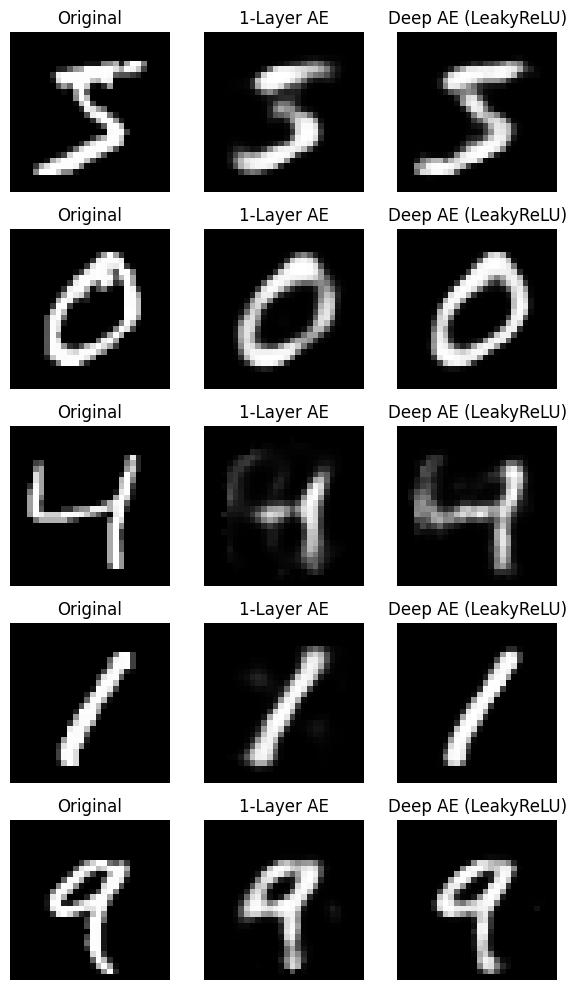

In [35]:
import matplotlib.pyplot as plt
import torch

# both set to eval mode
autoencoder.eval()
model.eval()

with torch.no_grad():
    # get same 5 images
    sample = X_tensor[:5]
    recon1 = autoencoder(sample) # 1-layer AE reconstruction
    recon2 = model(sample) # eakyReLU reconstruction

orig_np   = sample.cpu().numpy()
ae1_np    = recon1.cpu().numpy()
deep_np   = recon2.cpu().numpy()

# plot
n_show = orig_np.shape[0]
fig, axes = plt.subplots(n_show, 3, figsize=(6, 2*n_show))

for i in range(n_show):
    axes[i,0].imshow(orig_np[i].reshape(28,28), cmap='gray')
    axes[i,0].set_title("Original")
    axes[i,0].axis('off')
    
    axes[i,1].imshow(ae1_np[i].reshape(28,28), cmap='gray')
    axes[i,1].set_title("1-Layer AE")
    axes[i,1].axis('off')
    
    axes[i,2].imshow(deep_np[i].reshape(28,28), cmap='gray')
    axes[i,2].set_title("Deep AE (LeakyReLU)")
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

Here we compare the first 5 images for the original, 1layer AE, and LeakyReLU. <br>
There are 3 things that stood out to me the most when looking at these side by side.<br>
1. Deep AE was able to recreate strokes and backgrounds more accurately than the 1-layer <br>
        AE. Specifically the 4 looks more like a 4 than a 9 in the deep AE.
2. While 1-layer AE already had reduced ghosting when compared to PCA, the Deep AE extended <br>
        this and reduced it more.
3. Overall quality of the nunber is actualy better in Deep AE compared to the original <br>
        in some cases which I found surprising.